<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

A Loggi é uma startup brasileira de tecnologia focada em logística. Como toda empresa de logística, enfrenta problemas em uma base diária com as rotas e entregas. Nesse exercício vamos manipular alguns dados para criar insights que podem vir a ser úteis para a empresa tomar decisões a fim de aperfeiçoar seu processo de entregas, mais especificamente na região do Distrito Federal.

## 2\. Pacotes e bibliotecas

In [1]:
# Instalando e importando as bibliotecas que serão utilizadas no projeto de análise

!pip3 install geopandas

import json
import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np
import geopandas as geopd
import matplotlib.pyplot as plt
import seaborn as sns


## 3\. Exploração de dados

### 3.1 Coleta de dados


In [36]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

replace ./maps/ASB_Cemiterio_A.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### 3.2 Wrangling da estrutura

In [4]:
# Extraindo o dado bruto de um arquivo json e o alocando em um dict:
with open ('deliveries.json', mode='r', encoding='utf8') as arquivo:
  data = json.load(arquivo)

# Convertendo o dict em um DataFrame Pandas
deliveries_df = pd.DataFrame(data)

#Visualizar o DataFrame
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Observa-se que na coluna 'origin' temos dados da longitude e latitude dos hubs juntas. Vamos utilizar o método 'json_normalize' do Pandas para criar um novo DataFrame em que as informações da latitude e longitude dos hubs sejam separadas e alocadas em suas respectivas colunas.

In [5]:
# Criando um novo DataFrame separando as informações contidas na coluna 'origin'
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145
...,...,...
194,-47.893662,-15.805118
195,-47.802665,-15.657014
196,-47.893662,-15.805118
197,-48.054989,-15.838145


Com isso feito, vamos unir o novo DataFrame com o original e excluir a coluna 'origin' do DataFrame original.

In [6]:
# Unindo os DataFrames usando o método merge do Pandas
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df

,name,region,origin,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145
...,...,...,...,...,...,...,...
194,cvrp-1-df-59,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'fc800db1942651f8195f870c5930ca26', 'p...",-47.893662,-15.805118
195,cvrp-0-df-87,df-0,"{'lng': -47.802664728268745, 'lat': -15.657013...",180,"[{'id': '3d50e820e1c16621e1fa19f1a7df0c56', 'p...",-47.802665,-15.657014
196,cvrp-1-df-83,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'e6cffd090ce2a7bd0e0292f1ed9acd3', 'po...",-47.893662,-15.805118
197,cvrp-2-df-7,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '51b1354b02a20d919b83bb664ea4d845', 'p...",-48.054989,-15.838145


In [7]:
# Excluindo a coluna 'origin'
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df

,name,region,vehicle_capacity,deliveries,lng,lat
0,cvrp-2-df-33,df-2,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p...",-48.054989,-15.838145
1,cvrp-2-df-73,df-2,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po...",-48.054989,-15.838145
2,cvrp-2-df-20,df-2,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p...",-48.054989,-15.838145
3,cvrp-1-df-71,df-1,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p...",-47.893662,-15.805118
4,cvrp-2-df-87,df-2,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p...",-48.054989,-15.838145
...,...,...,...,...,...,...
194,cvrp-1-df-59,df-1,180,"[{'id': 'fc800db1942651f8195f870c5930ca26', 'p...",-47.893662,-15.805118
195,cvrp-0-df-87,df-0,180,"[{'id': '3d50e820e1c16621e1fa19f1a7df0c56', 'p...",-47.802665,-15.657014
196,cvrp-1-df-83,df-1,180,"[{'id': 'e6cffd090ce2a7bd0e0292f1ed9acd3', 'po...",-47.893662,-15.805118
197,cvrp-2-df-7,df-2,180,"[{'id': '51b1354b02a20d919b83bb664ea4d845', 'p...",-48.054989,-15.838145


In [8]:
# Reorganizando o Dataframe e renomeando as colunas 'lgn' e 'lat'
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."
...,...,...,...,...,...,...
194,cvrp-1-df-59,df-1,-47.893662,-15.805118,180,"[{'id': 'fc800db1942651f8195f870c5930ca26', 'p..."
195,cvrp-0-df-87,df-0,-47.802665,-15.657014,180,"[{'id': '3d50e820e1c16621e1fa19f1a7df0c56', 'p..."
196,cvrp-1-df-83,df-1,-47.893662,-15.805118,180,"[{'id': 'e6cffd090ce2a7bd0e0292f1ed9acd3', 'po..."
197,cvrp-2-df-7,df-2,-48.054989,-15.838145,180,"[{'id': '51b1354b02a20d919b83bb664ea4d845', 'p..."


Agora que resolvemos a parte do hub. Vamos olhar para a coluna deliveries. Podemos ver que há alguns dados juntos na mesma coluna, sendo necessário a manipulação desses dados para uma melhor compreensão da situação. Vamos começar usando o método 'explode' na coluna de interesse, que vai criar uma linha para cada elemento presente na coluna preservando o índice original.

In [9]:
# Executando o 'explode' na coluna 'deliveries'
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."
...,...
198,"{'id': '21693bf442ac5890adbdf2648c12881a', 'po..."
198,"{'id': '7aaa35088b37b6e542c4cd69663a7ebf', 'po..."
198,"{'id': '60c00d5390da4f28167439cd9c566703', 'po..."
198,"{'id': '51f456963785e7381243ff7baf7efd06', 'po..."


In [10]:
# Criar novos dataframes para cada informação contida em cada linha preservando os índices e depois concatenando os novos Dataframes
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["id"])).rename(columns={"deliveries":"delivery_id"})
], axis= 1)

deliveries_normalized_df

,delivery_size,delivery_lng,delivery_lat,delivery_id
0,9,-48.116189,-15.848929,313483a19d2f8d65cd5024c8d215cfbd
0,2,-48.118195,-15.850772,320c94b17aa685c939b3f3244c3099de
0,1,-48.112483,-15.847871,3663b42f4b8decb33059febaba46d5c8
0,2,-48.118023,-15.846471,e11ab58363c38d6abc90d5fba87b7d7
0,7,-48.114898,-15.858055,54cb45b7bbbd4e34e7150900f92d7f4b
...,...,...,...,...
198,8,-48.064269,-15.997694,21693bf442ac5890adbdf2648c12881a
198,4,-48.065176,-16.003597,7aaa35088b37b6e542c4cd69663a7ebf
198,9,-48.065841,-16.003808,60c00d5390da4f28167439cd9c566703
198,1,-48.062327,-16.001568,51f456963785e7381243ff7baf7efd06


In [11]:
# Agora vamos excluir a coluna deliveries do Dataframe original
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df

,name,region,hub_lng,hub_lat,vehicle_capacity
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180
...,...,...,...,...,...
194,cvrp-1-df-59,df-1,-47.893662,-15.805118,180
195,cvrp-0-df-87,df-0,-47.802665,-15.657014,180
196,cvrp-1-df-83,df-1,-47.893662,-15.805118,180
197,cvrp-2-df-7,df-2,-48.054989,-15.838145,180


In [12]:
# Acrescentando o DataFrame 'deliveries_normalized_df' no original.
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_id
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929,313483a19d2f8d65cd5024c8d215cfbd
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772,320c94b17aa685c939b3f3244c3099de
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871,3663b42f4b8decb33059febaba46d5c8
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471,e11ab58363c38d6abc90d5fba87b7d7
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055,54cb45b7bbbd4e34e7150900f92d7f4b
...,...,...,...,...,...,...,...,...,...
636144,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,8,-48.064269,-15.997694,21693bf442ac5890adbdf2648c12881a
636145,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,4,-48.065176,-16.003597,7aaa35088b37b6e542c4cd69663a7ebf
636146,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,9,-48.065841,-16.003808,60c00d5390da4f28167439cd9c566703
636147,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,1,-48.062327,-16.001568,51f456963785e7381243ff7baf7efd06


### 3.3 Exploração do schema

Temos agora os dados organizados em um só DataFrame. Vamos coletar algumas informações do dataframe.

In [13]:
# Mostra a dimensão do dataframe em linhas e colunas
deliveries_df.shape

(636149, 9)

In [14]:
# Tipos de dados presentes nas colunas e outras informações relevantes como o tamanho do arquivo.
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
 8   delivery_id       636149 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 43.7+ MB


In [15]:
# Informações dos atributos categóricos do DataFrame
atributos_cat = deliveries_df.select_dtypes("object").describe().transpose()
atributos_cat

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708
delivery_id,636149,291566,61b87669243974d021c2b76fc5272045,12


Dessa informação já podemos entender que a região com maior número de entregas é a df-1 com 304708.

In [16]:
# Informações dos atributos numéricos do DataFrame
atributos_num = deliveries_df.drop(["name", "region", "delivery_id"], axis=1).describe().transpose()
atributos_num

,count,mean,std,min,25%,50%,75%,max
hub_lng,636149.0,-47.949902,0.091875,-48.054989,-48.054989,-47.893662,-47.893662,-47.802665
hub_lat,636149.0,-15.802359,0.053463,-15.838145,-15.838145,-15.805118,-15.805118,-15.657014
vehicle_capacity,636149.0,180.000000,0.000000,180.000000,180.000000,180.000000,180.000000,180.000000
delivery_size,636149.0,5.512111,2.874557,1.000000,3.000000,6.000000,8.000000,10.000000
delivery_lng,636149.0,-47.946087,0.112769,-48.280779,-48.035911,-47.928967,-47.883394,-47.310611
delivery_lat,636149.0,-15.809492,0.082462,-16.050028,-15.842795,-15.814033,-15.769516,-15.500355


Dessa informação já podemos entender que não há variação na capacidade do veículo de transporte, já que todos tem capacidade para 180. O tamanho das entregas não variam muito, tendo um desvio padrão de 2.874557 que podemos entender como uma variação moderada.

## 4\. Manipulação

### 4.1 Enriquecimento

In [18]:
# Verificando a latitude e longitude dos 3 hubs do Distrito Federal
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [19]:
# Geocodificação Reversa das localizações dos hubs
geolocator= Nominatim(user_agent='ebac_geocoder', timeout=1000)
location= geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii= False))

geocoder= RateLimiter(geolocator.reverse, min_delay_seconds= 1)

{
  "place_id": 46410411,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.0533433333333333,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-127, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "state

In [20]:
# Criando as colunas 'coordinates' e 'geodata' e as adicionando no DataFrame 'hub_df'
hub_df['coordinates']= hub_df['hub_lat'].astype(str) + ', ' + hub_df['hub_lng'].astype(str)
hub_df['geodata']= hub_df['coordinates'].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [21]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.100010,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [22]:
# Selecionando as colunas de interesse e alterando nomes as informações de endereço dos hubs:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [23]:
# Combinando os DataFrames parar adicionar as colunas 'hub_suburb' e 'hub_city' no dataframe 'hub_df'
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()


,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [24]:
# Combinando os dataframes 'deliveries_df' e 'hub_df'
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


In [25]:
# Lendo o arquivo csv com os endereços de entrega e o transformando em dataframe
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()


,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [26]:
# Combinando os dataframes dos endereços de entrega com o dataframe 'deliveries_df'
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


### 4.2 Controle de qualidade

In [28]:
# Informações gerais do DataFrame 'deliveries_df'
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [29]:
# Identificando se há valores nulos nas colunas do dataframe
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [30]:
# Porcentagegm de valores nulos no dataframe das cidades de entrega
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

0.26754738276724477

In [32]:
# Porcentagemm de valores nulos no dataframe dos bairros de entrega
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

In [34]:
# Proporção do número de entregas por bairro
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
Name: count, dtype: float64

Salientando que Brasília não é considerado um bairro. Mas pela peculiaridade geográfica desse território brasileiro, a informação é útil para a análise.

## 5\. Visualização

In [39]:
# Leitura do mapa do Distrito Federal
mapa = geopd.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [41]:
# DataFrame das localizações e da geometria dos hubs
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopd.GeoDataFrame(hub_df, geometry=geopd.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [43]:
# Adicionando os pontos dos hubs ao dataframe 'deliveries_df'
geo_deliveries_df= geopd.GeoDataFrame(deliveries_df, geometry= geopd.points_from_xy(deliveries_df['delivery_lng'], deliveries_df['delivery_lat']))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


<ipython-input-44-dd7de00dff48>:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


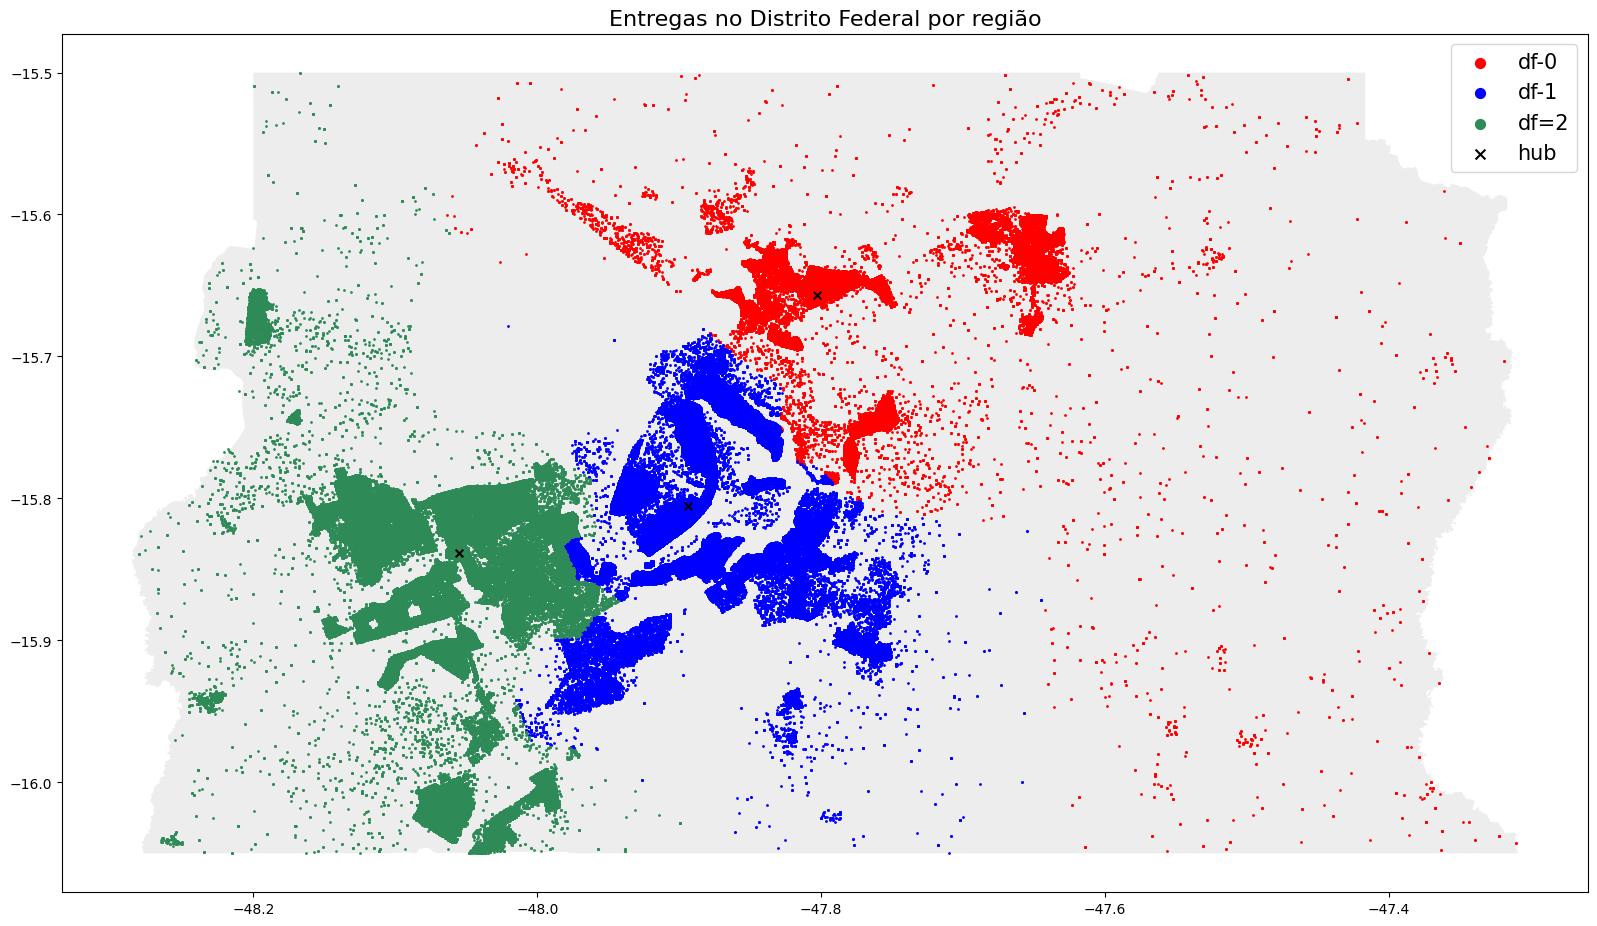

In [44]:
# Mapa:

# Criando o plot vazio:
fig, ax= plt.subplots(figsize= (50/2.54, 50/2.54))

# Plot do mapa do Distrito Federal:
mapa.plot(ax=ax, alpha= 0.4, color= 'lightgrey')

# Plot das entregas por suas regiões:
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize= 1, color= 'red', label= 'df-0')
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize= 1, color= 'blue', label= 'df-1')
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize= 1, color= 'seagreen', label= 'df=2')

# Plot da localização dos hubs:
geo_hub_df.plot(ax=ax, markersize= 30, marker= 'x', color= 'black', label= 'hub')

# Plot da legenda:
plt.title('Entregas no Distrito Federal por região', fontdict={'fontsize':16})
lgnd= plt.legend(prop={'size': 15})
for handle in lgnd.legendHandles:
  handle.set_sizes([50])

 - **Insights**:

Os hubs estão relativamente bem localizados e as entregas são feitas pelo hub mais próximo. Podemos observar que o hub da região df-1 tem trajetos menores que os hubs das regiões df-0 e df-2, já que há muitas entregas mais distantes porém são pontuais. Pode-se estudar a implementação de mais um hub nas regiões df-0 e df-2 se for viável.

In [50]:
# Proporção de entregas por região
data = pd.DataFrame(deliveries_df[['region']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,proportion
0,df-1,0.478988
1,df-2,0.410783
2,df-0,0.110229


<ipython-input-51-1a8be434694d>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="proportion", ci=None, palette="pastel")
<ipython-input-51-1a8be434694d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="proportion", ci=None, palette="pastel")


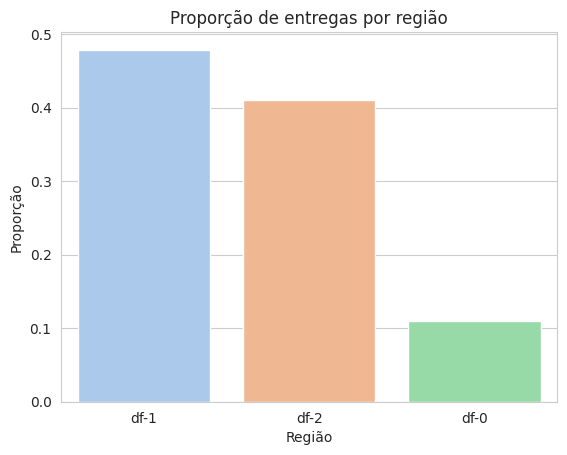

In [51]:
import seaborn as sns

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="proportion", ci=None, palette="pastel")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

- **Insights**:


Há um maior número de entregas nas regiões df-1 e df-2. A região df-0 tem consideravelmente menos entregas, mesmo sendo a maior região em tamanho territorial.

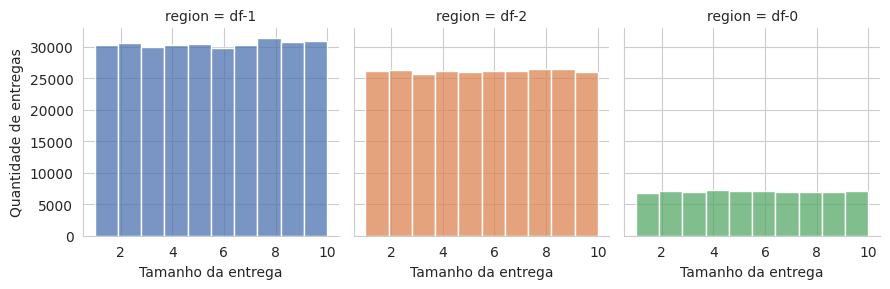

In [62]:
deliveries_size_df = deliveries_df[['region', 'delivery_size']]
with sns.axes_style('whitegrid'):
    image = sns.FacetGrid(deliveries_size_df, col='region', col_order=['df-1','df-2','df-0'], hue='region', hue_order=['df-1','df-2','df-0'], palette='deep')
    image.map(sns.histplot, 'delivery_size', bins=10)
    image.set(ylabel='Quantidade de entregas', xlabel='Tamanho da entrega')

- **Insights**:

O intuito dessa visualização seria observar se há algum padrão de tamanho da entrega por região, ou se algum tamanho de entrega é mais recorrente que outro. Porém, observamos que não há um padrão bem definido e que há um equilíbrio no tamanho das entregas.